## Hollowings
This notebook shows how a _hollowing_ (lavning) is computed. 

We determine if a house is located in a hollwoing and thus has an increased risk of flooding if heavy rain occurs. 

Data data comes from the _danish height model_ data set from [kortforsyningen](https://kortforsyningen.dk/indhold/webservice-liste-0). The data set is served in the [wms](https://en.wikipedia.org/wiki/Web_Map_Service) format. In short the data is returned as images where the pixal value for instance can indicate how big a hollowing is. 

The computation is split into the following steps:
1. *Adress lookup:* We convert an adress of the form `Kjærmarken 103, 6771 gredstedbro` into a set of longtitude and latitude. 
2. *Image retrival:* We convert the longtitude and latitude into images. 
    * Hollwowing Image: An image that shows where flooding might occur. 
    * Bulding Image: An image showing the location of buldings in the area. 
3. *Compute the risk:* We transform the images and compute the overlap between buldings and hollowings
4. *Construct final image:* To add transparency we combine the data images with a satelite image which ilustrates the computation and can be shown to the end user. 

> The code in this notebook is structed as a python module such that it easily can be imported and exposed by a python REST server, follow the import statements to see the code

> **Required:** The code assumes that the enviroment variable `KORTFORSYNINGEN` is set to a valid user and password of the form `user@password`

In [3]:
import os, sys
%load_ext autoreload
%autoreload 2
sys.path.append(os.path.pardir)

### Address lookup
We start by creating a function that can convert text adresses to coordinates, we use the [Dawa API](https://dawa.aws.dk/dok/api) to perform the lookups

In [4]:
from data_retrival import addressToLatLong
x, y = addressToLatLong("Kjærmarken 103, 6771 Gredstedbro")
assert x == 55.40156089
assert y == 8.74228813

#### Bouding box
To be able to retrive an image from a [WMS api](https://docs.geoserver.org/stable/en/user/services/wms/reference.html) with a langtitude and latitude pair we must compute a bounding box of the format `minx,miny,maxx,maxy`.

Dawa uses the [EPSG:4326](https://epsg.io/4326) projection which corrosponds to standard GPS coordinates. The WMS Api uses the [ESPG spatial refrence system](https://en.wikipedia.org/wiki/Spatial_reference_system), we specify the [EPSG:3857](https://epsg.io/3857) projection wich uses meters as units. 

We want to be able to specify a bounding box that has the latitude and longtidue as center of the box and then specify how many meters the box should extend in each direction. 

The steps of computing the bounding box is thus.
1. Convert from langtitude lotitude to EPSG:3857 projection. 
2. Create a box that has the specifyed with and height with the point in the center. 



In [5]:
from data_retrival import convertEPSG
x, y = addressToLatLong("Kjærmarken 103, 6771 Gredstedbro")
x, y = convertEPSG(x, y)
assert x == 973187.0629996799
assert y == 7440194.196982217

/usr/local/lib/python3.7/site-packages/pyproj/transformer.py:92: UserWarning: `from_crs` is deprecated and will be removed in 2.2.0. Please use `from_proj` instead.
  "`from_crs` is deprecated and will be removed in 2.2.0. "


In [6]:
from data_retrival import boundingBox
assert boundingBox(0,0, boxSize=2) == '-1.0,-1.0,1.0,1.0'

In [7]:
from data_retrival import getImg
imageSize = 800

img = getImg(973187.0629996799,7440194.196982217, 'buildings', imageSize=imageSize)
assert img.size == (imageSize, imageSize)

In [8]:
from hollowings import addressToImages
address = 'Dronning Dagmars vej 13, 6760 Ribe'     
buildImg, hollowImg, mapImg = addressToImages(address)

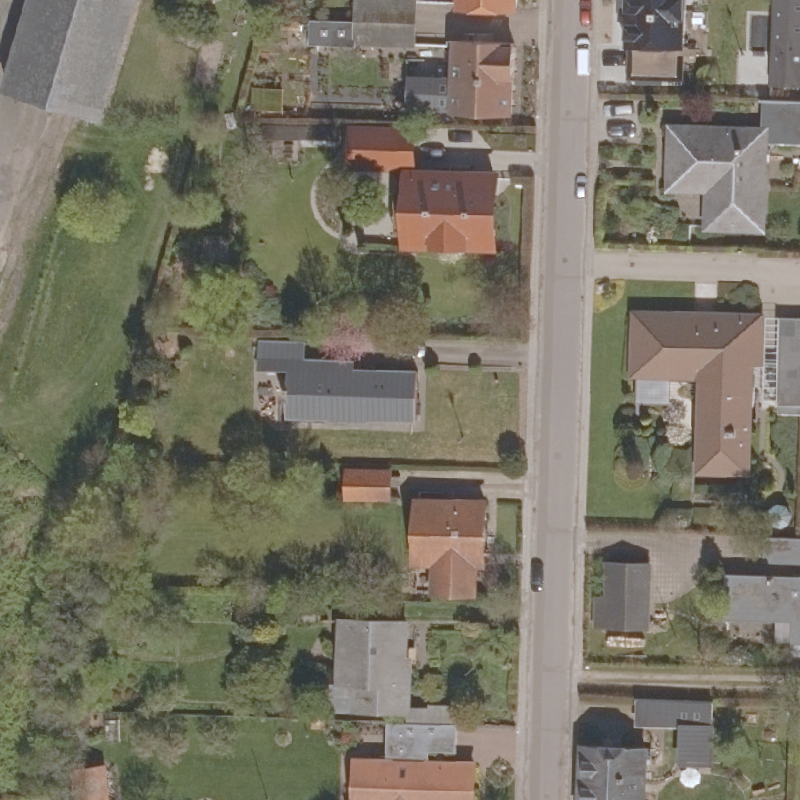

In [9]:
mapImg

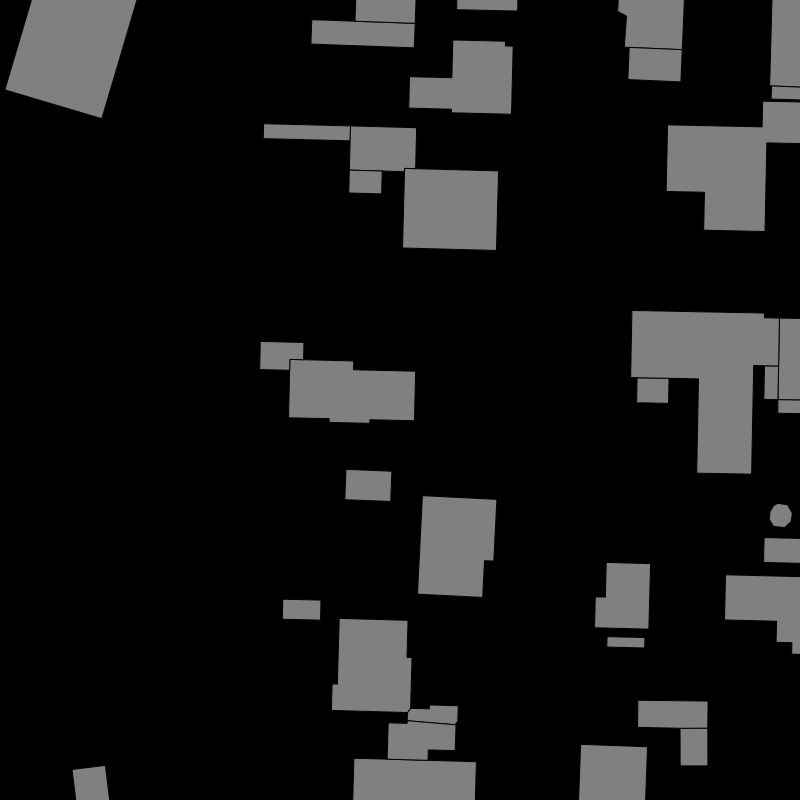

In [10]:
buildImg

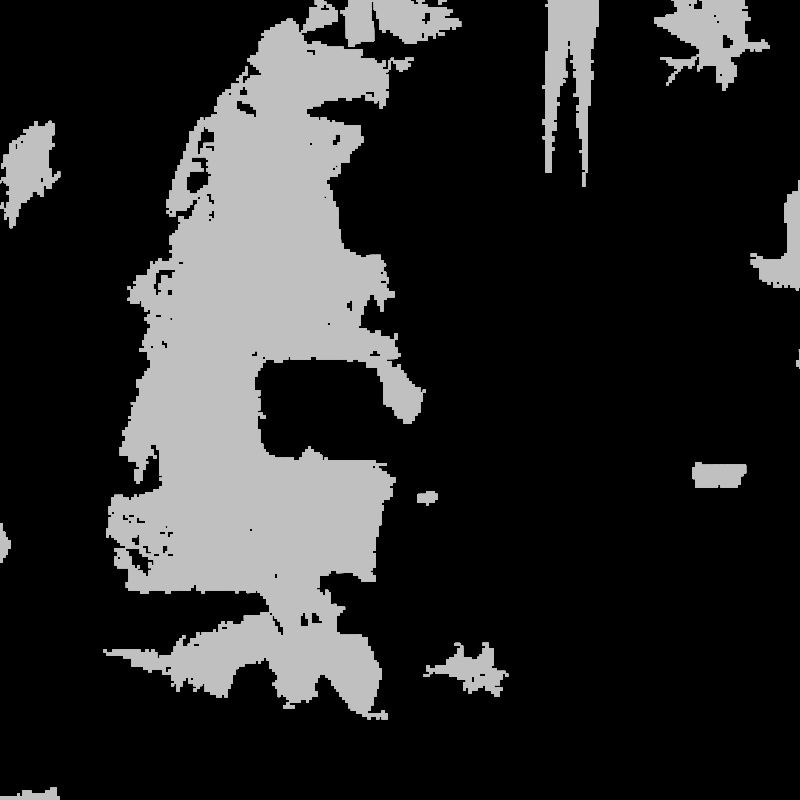

In [11]:
hollowImg

### Computing the values
As seen above we are now able to retrive bulding and hollowing data for an abitrary house. 

The next goal is to determine if there is a hollwoing in the specific bulding. The algorithm consists of the following steps. 
1. Isolate the main bulding on the property
2. Convert the building image to a binary image
3. Filter hollowings that are not touching a house
4. Count the number of pixels that is touching the house. 

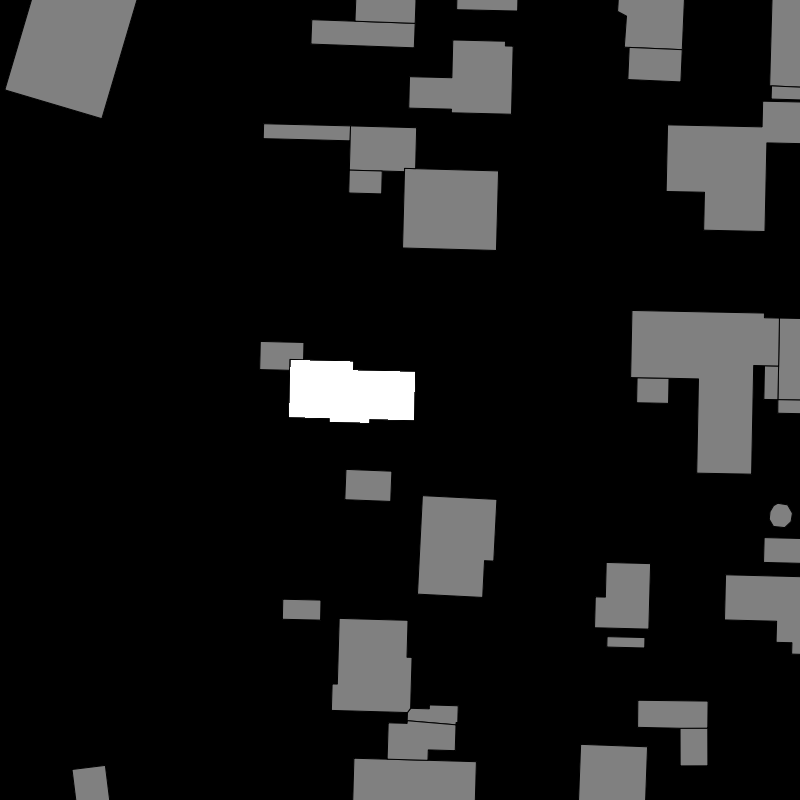

In [12]:
from image_handling import isolateBuilding
isolateImg = isolateBuilding(buildImg)
isolateImg

#### Transforming the images
We are able to isolate the bulding and retrive hollwoings for the area. 
The next step is to use the isolated bulding as a filter on the hollwoing image and only show the hollowings that are touching the house. 

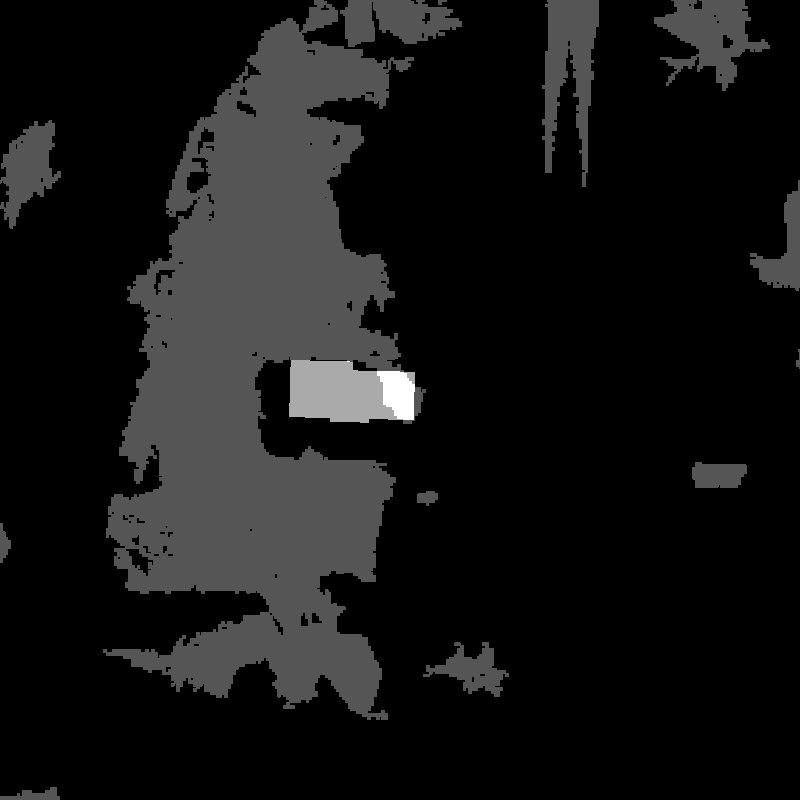

In [13]:
from image_handling import imageToBlackWhite, combineImages
combined = combineImages(
    imageToBlackWhite(hollowImg, thresshold=10),
    imageToBlackWhite(isolateImg)
)
combined

## Summary
We are now able to input an address and return the number of pixels of the house that touches a hollowing. We can also generate a picture that ilustrates the situation for the house

The number of pixel with a hollowing touching the house is 1337


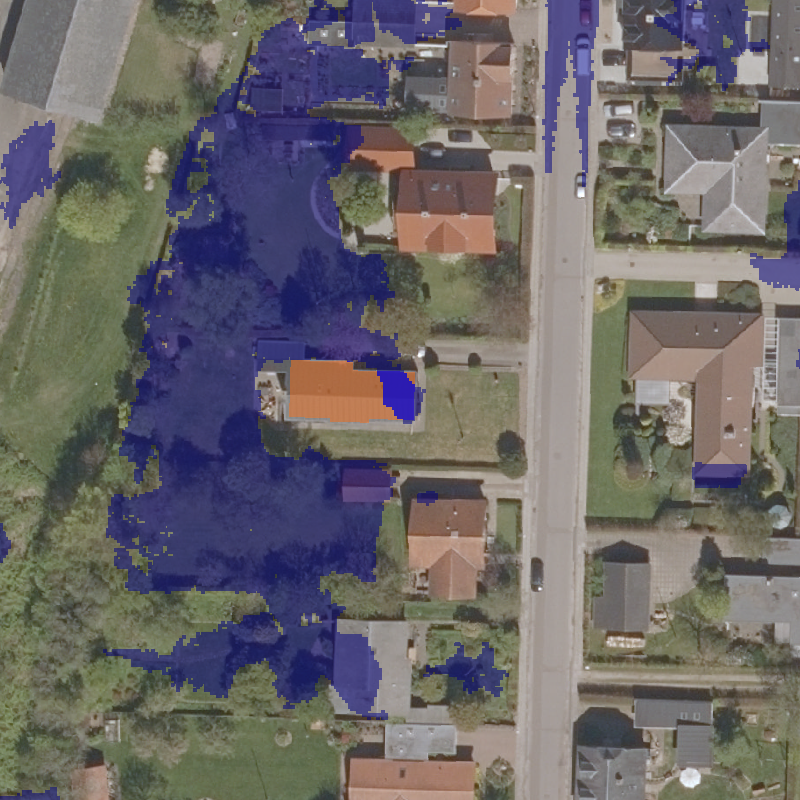

In [14]:
from hollowings import checkHollowing
count, img = checkHollowing('Dronning Dagmars vej 13, 6760 Ribe')
print(f'The number of pixel with a hollowing touching the house is {count}')
img

In [15]:
from hollowings import getHollowingResponse
getHollowingResponse('kjærmarken 103, 6771 gredstedbro')

{'house_area_percentage': 0.0,
 'house_amount': 0.1037375,
 'image': b'iVBORw0KGgoAAAANSUhEUgAAAyAAAAMgCAIAAABUEpE_AAEAAElEQVR4nFz9aZNty3Ydho3ZZK61dlNVp7nn3ndfi1YkQVMQLZEUCUpk2OFw2JYsy1YEbX9z-O_4oz_KP8CSw6ZDjDBt2SQhAqBs2QRBAGwAvAfgNbc5TTW7Wysz55z-kGvXuVCd9-45956qXbvWypU55hhjjkn_67_zvwvwf_I_G4Gq41Ywep3_s__rTCREiHB3M_Nw_C__zh2JIbjM5fD4_nI6ApSy7G4-STnPy-nx_r6cj8tyPp7O0zAO0zSMmzyMOWfVJMIpjyyCCK_FvXHSNA4UatZaLVaKu7MwCZNR2ijLRCHeirfZzUCcNoOAKQREQR4wOCMA5oBbq24WERZNKEVEwAASFmYNMEVEtIiIgCMioGkIiBO52VLa-bzMZTkfT28fj--_-jrrGDmZt6guSVTTbr_3iKRKRMsyPz4dOYq3dvPy26IedebAdr9Lux1ZOx8PkpMyE3O5lGEYW6sPHx4fn95T2P7mBYJuX9zs9rvNOJU6l1IUAgAMTpp1cNjpMs-XAsZ8Xh4_fHj48O7b3_-5159-K5iPjx-OD2-fHt5dLpe2XHIehnGTxlFEWMQjDo-PtRQzY5JlOYW1cZzGaZOEhTjlUVVTUlFl5nHciqZ5mY8PH86HJws4UTmf2Gn34vZb3_7Bi09uSzk9fnhEPavugmD14sURzOIsApCTS1BdiqbESfd3L__7_9H_6un-_eHw9vh0vpzOx8PbeSnf--7PXUo7PNxfTkcSYYKVYubmNSKYOQjmlnIaUmbiFiyakkgpy4eHh8fHp8v50lqknJnjeHhy90_efPr680-Ob9-WdqaUFHnYJBrSfMJv__Pff3g8EoREqll4CCWrNSLgDAAURCAI1yOHKZCYR-EpcRb87